In [330]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob

In [ ]:
#load the the files with labels
#labels are based on KMeans clustering in the data prepropeccing file
#this create a master dataframe with all 56 files concatenated.
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))  #capture all.csv files in the path
master_df=pd.read_csv(csv_files[0])
id=int(csv_files[0].split('/')[-1].split('.')[0]) #create the master_Df 
master_df['id']=id
#loop through to concate and add the vehicled id to the dataframe for identification
for i in range(1,len(csv_files)):
    data=pd.read_csv(csv_files[i])
    id=int(csv_files[i].split('/')[-1].split('.')[0])
    data['id']=id
    new=pd.concat([master_df,data])
    master_df=new

In [33]:
#master_df.to_csv('train.csv',index=None) #save the master)Df

In [57]:
#create the test and train data by withholding one driver information
#in this case we held out vehicle id =122196196
test=master_df[master_df['id']==122196196]
train=master_df[master_df['id']!=122196196]

In [186]:
#split the train and test data to have X and y for fitting 
#the Xtrain and X_test
X_train=train.drop(['label','id'],axis=1)
X_test=test.drop(['label','id'],axis=1)

#the values are too big and we scalled them using the standard scaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

#the ytrain and y_test
y_train=train.label
y_test=test.label

#initiali the decision tree classifier 
#and fit the model
#one can used different models as it may be needed
model=DTC()
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [329]:
#test the accuracy of the model with held-out data(vehicle id =122196196)
print(f"The accuracy of the DTC model is {model.score(X_test,y_test)*100} %")

The accuracy of the DTC model is 83.72093023255815 %


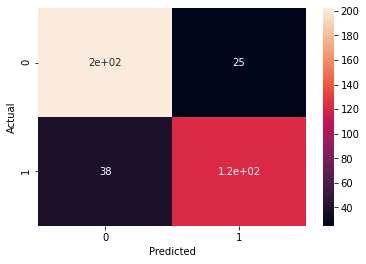

In [298]:
#plot the heatmap of the actual vs predictions
sns.heatmap(confusion_matrix(model.predict(X_test),np.array(y_test)),annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [331]:
#calculate the f1_score, it tells more info than the accuracy
f1_scor=f1_score(model.predict(X_test),np.array(y_test))
print(f"The accuracy of the DTC model is {f1_scor*100} %")

The accuracy of the DTC model is 79.47882736156352 %


In [ ]:
# let's use the model created to predict the full set again, then create a profile with a driver score
#this score will be compared with insurance claims to confirm the predictions

In [383]:
# #load the data in the testing folder and concat to one df
#load the data that had no labels

#initialize the path and create a master test dataframe that contains
#all the files that had been left out
d='/home/joemuthui/Documents/Standard_hackathon/telematics_data/testing_data' 
test_files=glob.glob(os.path.join(d, "*.csv"))
master_test=pd.read_csv(test_files[0])
id=int(test_files[0].split('/')[-1].split('.')[0])
master_test['id']=id
for i in range(1,len(test_files)):
    data=pd.read_csv(test_files[i])
    id=int(test_files[i].split('/')[-1].split('.')[0])
    data['id']=id
    new=pd.concat([master_test,data])
    master_test=new

In [384]:
#prepare the data by dropping the id and predicting the labels
ids=master_test['id']
test_data=master_test.drop('id',axis=1)
scaled_test=scaler.fit_transform(test_data)
pred=model.predict(scaled_test) #predicted labels

In [385]:
#create a data frame with the id and predicted label
#the label=1 means there is a possibility of a risky moment during that window
predicted_df=pd.DataFrame()
predicted_df['id']=ids.values
predicted_df['label']=pred
train_df=master_df[['id','label']]
###mean of risky moments per car
test_data=predicted_df.groupby('id')['label'].mean()
train_dat=train_df.groupby('id')['label'].mean()

In [386]:
#full profile
#combine the data i.e test_Data and train_dat
full_profile=pd.concat([train_dat,test_data])
#convert the risk to percentage and create a full dataset
val=full_profile.values*100
ind=full_profile.index
full_profile=pd.DataFrame()
full_profile['vehicleid']=ind #id is the vehicle id
full_profile['risk']=val #value is the risk

In [388]:
#import the claims in order to overlay in our analysis
#fill the nan with zero
fil=glob.glob(os.path.join("/home/joemuthui/Documents/Standard_hackathon/OneDrive_1_2023-08-11/","*.csv"))
claims=pd.read_csv(fil[0])

In [391]:
#we noted that some cars in the claim are not in the complete list due to insufficient dta
#this is removed
fp=set(full_profile.vehicleid.values)
cl=set(claims.vehicleid.values)
out=list(cl-fp)
claims=claims.drop(claims[claims.vehicleid.isin(out)].index)

In [ ]:
#merge the cliams and risk dataset 
#into the complete_df
complete_df=pd.merge(full_profile,claims,on='vehicleid')
complete_df=complete_df.replace(np.nan,0)

In [392]:
#the total claims cost has large numbers
#e devide by the max value of the cost
complete_df['total claims cost']=complete_df['total claims cost']/max(complete_df['total claims cost'])

In [393]:
#plot the bar of for the cost and risk plot
plt.bar(np.arange(15),complete_df['total claims cost'][0:15],label='claims_cost')
plt.plot(complete_df['risk'][0:15]/100,c='red',label='risk')
plt.legend()
plt.xlabel('Id')
plt.ylabel('risk/claims')
plt.show()

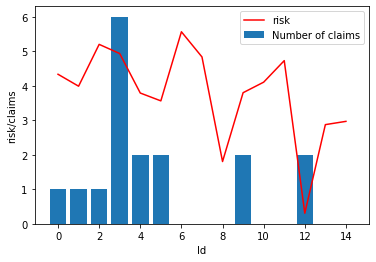

In [401]:
#plot the bar of for the number of claims and risk plot
plt.bar(np.arange(15),complete_df['number of claims'][0:15],label='Number of claims')
plt.plot(complete_df['risk'][0:15]/10,c='red',label='risk')
plt.legend()
plt.xlabel('Id')
plt.ylabel('risk/claims')
plt.show()